In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
end_date = datetime.today()
start_date = datetime(2000, 1, 1)

spx = yf.download('^GSPC', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:

price_chg = np.log(spx['Close']) - np.log(spx['Close'].shift(1))  # shift 1 shifts forward one day; today has yesterday's price
volume_chg = np.log(spx['Volume']) - np.log(spx['Volume'].shift(1))  # shift 1 shifts forward one day; today has yesterday's price
price_chg = price_chg * 100.0
volume_chg = volume_chg * 100.0
price_chg.dropna(inplace=True)
volume_chg.dropna(inplace=True)
print(price_chg.shape, volume_chg.shape)

(6560, 1) (6560, 1)


/opt/miniconda3/lib/python3.13/site-packages/pandas/core/internals/blocks.py:347: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [9]:
## Contemporaneous correlations between return and trading volume is less significant than absolute return and trading volume
data = pd.concat([price_chg, volume_chg], axis=1)
data.columns = ['Price', 'Volume']
data = data.dropna()  
data = data.replace([np.inf, -np.inf], np.nan).dropna()  
print(data.corr())

data_abs = pd.concat([np.abs(price_chg), volume_chg], axis=1)
data_abs.columns = ['Price', 'Volume']
data_abs = data_abs.dropna()
data_abs = data_abs.replace([np.inf, -np.inf], np.nan).dropna()
print(data_abs.corr())

           Price    Volume
Price   1.000000 -0.058313
Volume -0.058313  1.000000
           Price    Volume
Price   1.000000  0.115149
Volume  0.115149  1.000000


In [10]:
# train test split
data_training = data.iloc[:-22]
data_test = data.iloc[-22:]
model = VAR(data_training)

/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:

ms = model.select_order(45)      # 45 business days, roughly two months
ms.summary()

,AIC,BIC,FPE,HQIC
0,6.239,6.241,512.2,6.239
1,6.104,6.110,447.5,6.106
2,6.063,6.073,429.6,6.067
3,6.030,6.045,415.9,6.035
4,6.011,6.030,407.8,6.017
5,6.007,6.030,406.1,6.015
6,6.004,6.031,405.0,6.013
7,5.997,6.028,402.2,6.008
8,5.985,6.020,397.3,5.997
9,5.973,6.013*,392.8,5.987


In [12]:

results  = model.fit(maxlags=45, ic='aic')

In [13]:
	

# best lag order is 32, around 6 weeks
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Feb, 2026
Time:                     21:52:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.08467
Nobs:                     6502.00    HQIC:                   5.99054
Log likelihood:          -37627.3    FPE:                    380.228
AIC:                      5.94077    Det(Omega_mle):         372.285
--------------------------------------------------------------------
Results for equation Price
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.031714         0.015158            2.092           0.036
L1.Price          -0.099190         0.012499           -7.936           0.000
L1.Volume         -0.001824         0.000940           -1.940           

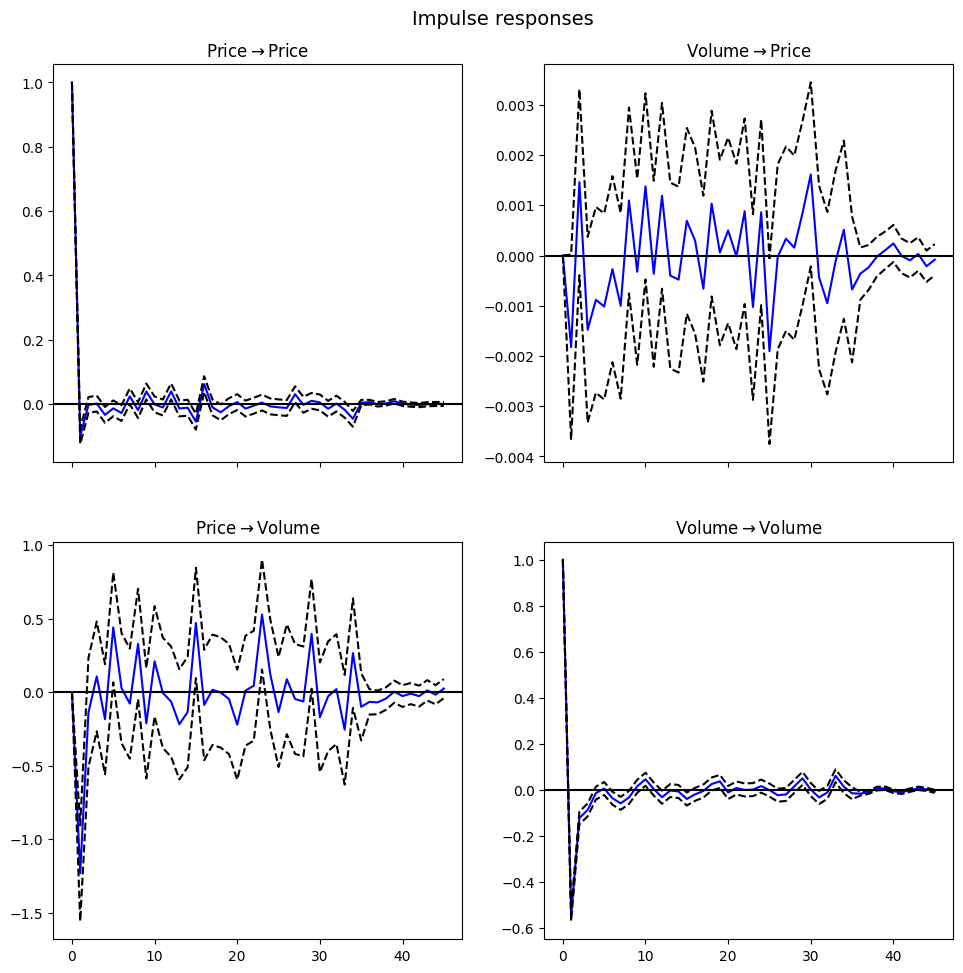

In [14]:
# volume --> price has positive shocks which dies out over time; which matches our intuition.
# volume --> volume has negative shocks; suggests mean reversion
irf = results.irf(45)
irf.plot(orth=False);
# irf.plot(impulse='Volume');

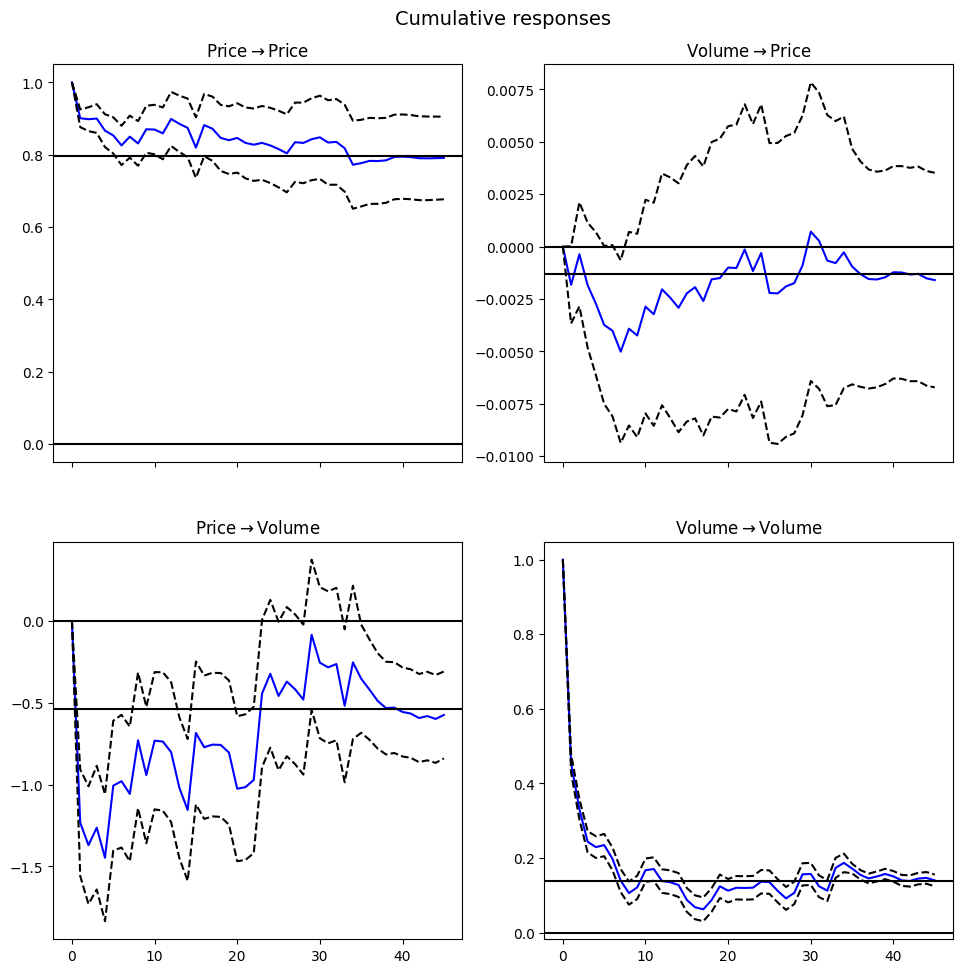

In [15]:

irf.plot_cum_effects(orth=False);

FEVD for Price
        Price    Volume
0    1.000000  0.000000
1    0.999421  0.000579
2    0.999051  0.000949
3    0.998672  0.001328
4    0.998539  0.001461
5    0.998361  0.001639
6    0.998349  0.001651
7    0.998177  0.001823
8    0.997970  0.002030
9    0.997955  0.002045

FEVD for Volume
        Price    Volume
0    0.007272  0.992728
1    0.007231  0.992769
2    0.007149  0.992851
3    0.007289  0.992711
4    0.007407  0.992593
5    0.008206  0.991794
6    0.008218  0.991782
7    0.008198  0.991802
8    0.008754  0.991246
9    0.008975  0.991025




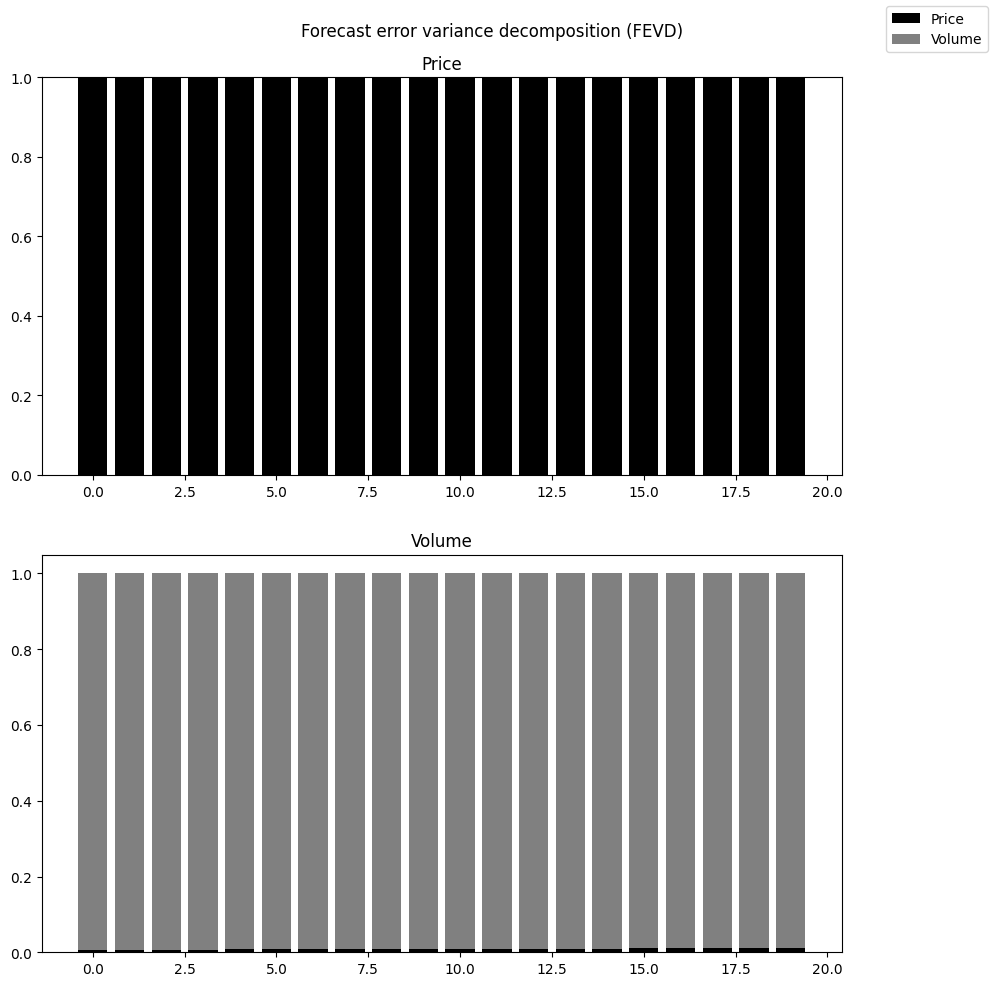

In [16]:

# autocorrelation with itself dominates
fevd = results.fevd(10)
fevd.summary()
results.fevd(20).plot();

In [17]:

gc = results.test_causality('Price', ['Price', 'Volume'], kind='f')
gc.summary()

Test statistic,Critical value,p-value,df
3.154,1.299,0.000,"(68, np.int64(12866))"


In [18]:

# H_0 rejected; Volume has incremental explanation power.
gc = results.test_causality('Price', ['Volume'], kind='f')
gc.summary()
     

Test statistic,Critical value,p-value,df
0.9444,1.430,0.560,"(34, np.int64(12866))"


In [19]:

# Normality is rejected; the model needs improvements; probably GARCH.
nt = results.test_normality()
nt.summary()

Test statistic,Critical value,p-value,df
4.839e+04,9.488,0.000,4


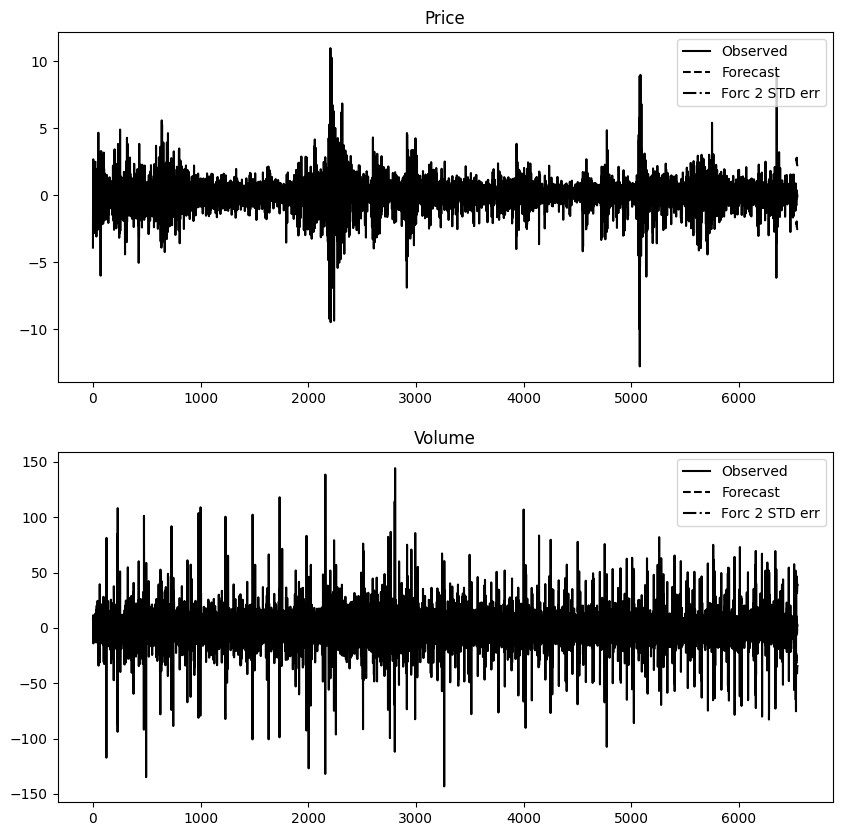

In [20]:

# forecast
results.plot_forecast(10);

In [21]:

lag_order = results.k_ar
# results.forecast(data.values[-lag_order:], 5)
m, l, u = results.forecast_interval(data.values[-lag_order:], data_test.shape[0])

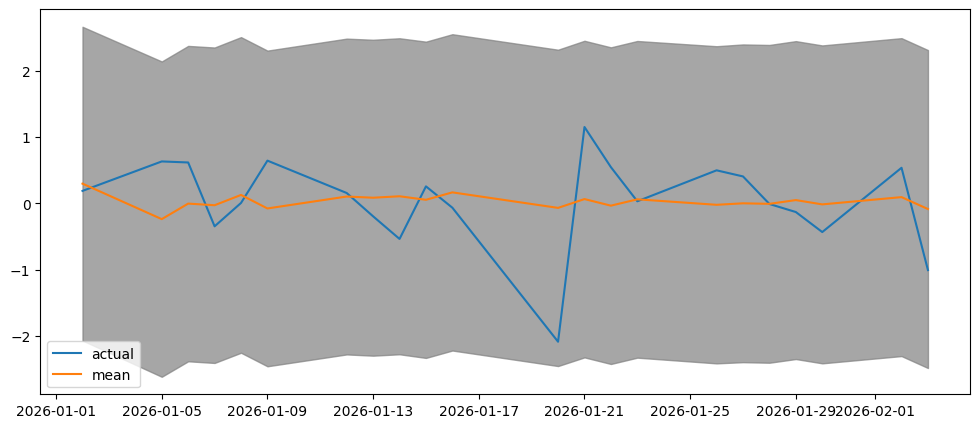

In [22]:
# Return forecast
plt.figure(figsize=(12, 5))
plt.plot(data_test['Price'], label='actual')
plt.plot(pd.DataFrame(m[:, 0], index=data_test.index), label='mean')
plt.fill_between(data_test.index, l[:, 0], u[:, 0], color='gray', alpha=0.7)
plt.legend()
plt.show()

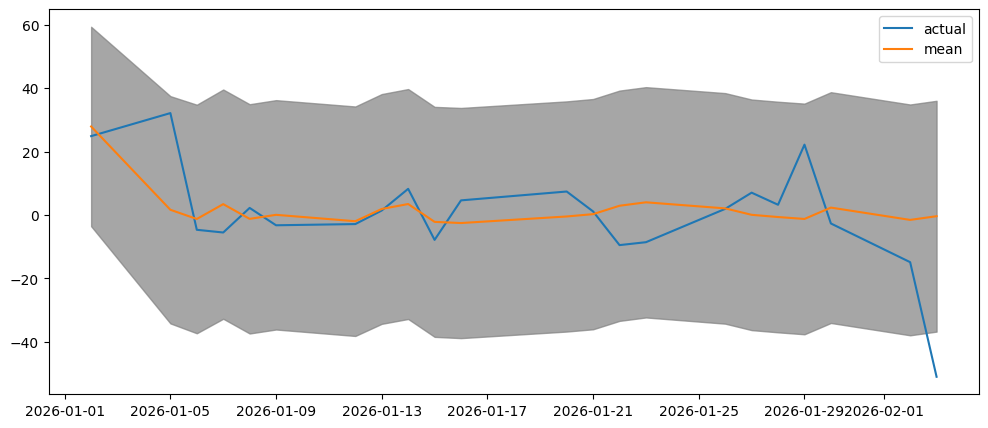

In [23]:

# volume forecast
plt.figure(figsize=(12, 5))
plt.plot(data_test['Volume'], label='actual')
plt.plot(pd.DataFrame(m[:, 1], index=data_test.index), label='mean')
plt.fill_between(data_test.index, l[:, 1], u[:, 1], color='gray', alpha=0.7)
plt.legend()
plt.show()